## Market Data

Equity의 가장 기본은 가격 데이터이다. 이번 시간에는 자산 가격 데이터의 여러 형태를 확인하고, 이를 능숙하게 다루는 것을 목표로 한다.

In [1]:
import numpy as np
import pandas as pd

### 1. OHLCV Data

가장 기본적으로 제공되는 데이터이다. 시가, 고가, 저가, 종가, 거래량으로 컬럼이 구성되어 있다. 가격 데이터를 가져오는 가장 대표적인 라이브러리인 Yahoo finance 라이브러리 (`yfinance`)가 최근 0.2.54 버전으로 업데이트되며 사용 방법이 바뀌었다. yfinance의 업데이트 이후 수정가격이 더 이상 OHLCV 데이터와 함께 표시되지 않으며, 기본적으로 수정가격을 불러오도록 `auto_adjust = True`로 되어 있다.

In [7]:
import yfinance as yf

data = yf.download(
    ['AAPL'],
    start = '2020-01-01',
    end = '2025-02-22',
    interval = '1d', # 데이터 추출 빈도 (기본값 : 1일)
    progress = False, # 다운로드 시 progress bar 표시 여부
    auto_adjust = True, 
    multi_level_index = False # Multi Index형태의 컬럼 지정 해제
)

수정가격이 아닌 당시 거래가격을 보기 위해서는 parameter에서 `auto_adjust = False`로 지정해야 한다.

In [8]:
non_adjusted_data = yf.download(
    'AAPL',
    start = '2020-01-01',
    end = '2025-02-22',
    interval = '1d', # 데이터 추출 빈도 (기본값 : 1일)
    progress = False, # 다운로드 시 progress bar 표시 여부
    auto_adjust = False, # 시가, 고가, 저가, 종가를 모두 수정가격으로 주지 않는다
    multi_level_index = False # Multi Index형태의 컬럼 지정 해제
)

In [9]:
non_adjusted_data

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,72.716064,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,72.009125,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.582886,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,72.241547,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08,73.403641,75.797501,76.110001,74.290001,74.290001,132079200
...,...,...,...,...,...,...
2025-02-14,244.600006,244.600006,245.550003,240.990005,241.250000,40896200
2025-02-18,244.470001,244.470001,245.179993,241.839996,244.149994,48822500
2025-02-19,244.869995,244.869995,246.009995,243.160004,244.660004,32204200


실제로, 수정종가와 원본 종가는 가격 차이가 존재한다. 이는 과거 시점으로 가면 갈수록 차이가 벌어진다.

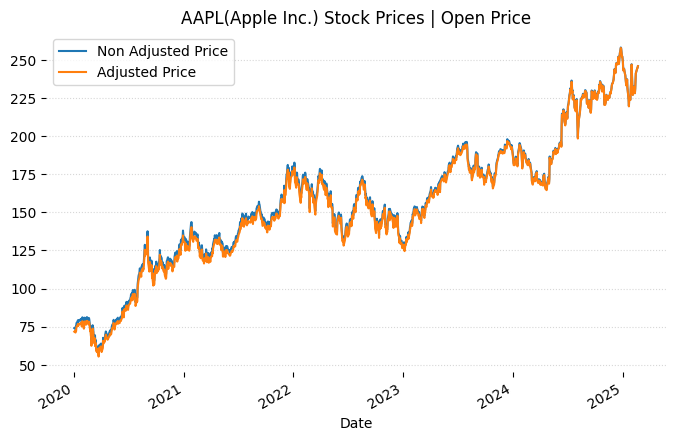

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
non_adjusted_data['Open'].plot(ax = ax, label = 'Non Adjusted Price')
data['Open'].plot(ax = ax, label = 'Adjusted Price')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'AAPL(Apple Inc.) Stock Prices | Open Price')
plt.show()

#### 1.1 수정 종가에 대한 처리

- 수정 종가는 역사적 거래 가격에서 **배당가치, 액면분할/병합**을 고려한 가격으로, 호출 시점마다 **가격이 달라진다**
- Yahoo Finance의 경우, 수정종가가 아닌 역사적 거래 가격 또한 액면분할과 액면병합 등의 효과는 이미 반영이 되어 있다
- 수정 종가를 사용할지, 역사적 거래 가격을 사용할지는 프로젝트의 성격과 목적에 따라 다르다.
    - 예시 : 가격 데이터베이스 구축의 경우 항상성이 유지되지 않는 수정종가를 적재하면 안됨

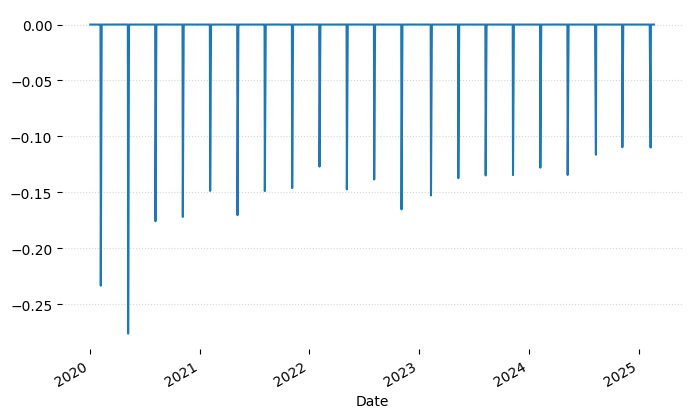

In [11]:
fig, ax = plt.subplots(figsize = (8, 5))
((non_adjusted_data['Close'].pct_change() - data['Close'].pct_change()) * 100).plot(ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

실제로 수정종가의 수익률과 원본 종가의 수익률을 차감하면 다음과 같이 배당 주기가 보이는 것을 확인할 수 있다. 

전략의 구성과 백테스팅에서는 배당 수익률 또한 포트폴리오의 수익에 포함되므로, 수정종가로 시뮬레이션 하는 것을 권장한다.

#### 1.2 Frequency Resampling

부득이하게 일별 데이터를 주간 혹은 월간 데이터로 바꿔야 하는 경우가 있다. 이 경우 어떤 식으로 해야 데이터의 무결성을 이어갈 수 있을지 확인해 보자.

**yahoo finance로부터 추출 주기를 직접 요청**

`interval='1wk'`로 지정함으로써 주간 데이터를 직접 요청할 수 있다. 그러나, 이 경우 인덱스 불일치 등의 문제가 발생하므로, daily data 기준으로 작업하는 것이 훨씬 현명하다.

In [12]:
data_week = yf.download(
    ['AAPL'],
    start = '2020-01-01',
    end = '2025-02-22',
    interval = '1wk', # 데이터 추출 빈도 (기본값 : 1주)
    progress = False, # 다운로드 시 progress bar 표시 여부
    auto_adjust = True, 
    multi_level_index = False # Multi Index형태의 컬럼 지정 해제
)

In [13]:
data_week

,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,72.241547,72.849224,70.876074,71.721016,509062400
2020-01-08,75.701187,76.885081,71.943730,71.943730,726318800
2020-01-15,76.643013,77.236165,74.943435,75.500280,479412400
2020-01-22,76.914177,78.279642,73.812819,77.129646,677016000
2020-01-29,77.194984,79.373924,73.168787,78.550770,852965600
...,...,...,...,...,...
2025-01-22,237.998322,239.926210,219.548605,219.548605,349630200
2025-01-29,232.544327,246.918522,225.452118,233.862869,320350100
2025-02-05,232.364517,234.971651,226.950472,228.279013,196086800


In [15]:
data_week.index

DatetimeIndex(['2020-01-01', '2020-01-08', '2020-01-15', '2020-01-22',
               '2020-01-29', '2020-02-05', '2020-02-12', '2020-02-19',
               '2020-02-26', '2020-03-04',
               ...
               '2024-12-18', '2024-12-25', '2025-01-01', '2025-01-08',
               '2025-01-15', '2025-01-22', '2025-01-29', '2025-02-05',
               '2025-02-12', '2025-02-19'],
              dtype='datetime64[ns]', name='Date', length=269, freq=None)

In [16]:
data_week.index.weekday

Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       ...
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype='int32', name='Date', length=269)

**Daily Data로부터 직접 재표본추출**

Daily data로 작업하면 다음과 같은 이점이 생긴다.

- 본인이 어떤 요일을 기준으로 가격을 재추출하였는지 명확하다.
- 인덱스 설정에 불필요한 실수를 줄일 수 있다.

주의할 점은, 종가의 경우 추출요일 기준 마지막 값을 가져와야 하고, 시가는 최초 가격을 가져와야 한다. 

In [17]:
RESAMPLE_FREQ = 'W-FRI' # 금요일 기준으로 종가 추출
data_new_week = pd.DataFrame(dtype = float)

data_new_week['Open'] = data['Open'].resample(RESAMPLE_FREQ).first() # 시가 중 가장 최초 가격, 월요일 시가
data_new_week['High'] = data['High'].resample(RESAMPLE_FREQ).max() # 고가 중 가장 높은 가격
data_new_week['Low'] = data['Low'].resample(RESAMPLE_FREQ).min() # 저가 중 가장 낮은 가격
data_new_week['Close'] = data['Close'].resample(RESAMPLE_FREQ).last() # 주간 종가의 가장 마지막 종가
data_new_week['Volume'] = data['Volume'].resample(RESAMPLE_FREQ).sum() # 주간 거래량은 일간 거래량의 총합

In [18]:
data_new_week

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-03,71.721011,72.776591,71.466805,72.009125,281803200
2020-01-10,71.127844,75.698802,70.876053,75.132271,670091600
2020-01-17,75.449437,77.168355,74.943424,77.165939,652055600
2020-01-24,76.793094,78.279616,76.420257,77.064255,463685200
2020-01-31,75.066912,79.373944,73.812813,74.933739,866734800
...,...,...,...,...,...
2025-01-24,223.753984,226.780662,219.139063,222.535324,277129600
2025-01-31,223.773962,246.918527,223.733997,235.740814,372790500
2025-02-07,229.737419,233.743004,225.452122,227.380005,227383400


In [19]:
data_new_week.index

DatetimeIndex(['2020-01-03', '2020-01-10', '2020-01-17', '2020-01-24',
               '2020-01-31', '2020-02-07', '2020-02-14', '2020-02-21',
               '2020-02-28', '2020-03-06',
               ...
               '2024-12-20', '2024-12-27', '2025-01-03', '2025-01-10',
               '2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07',
               '2025-02-14', '2025-02-21'],
              dtype='datetime64[ns]', name='Date', length=269, freq='W-FRI')

**주간 최종 영업일 기준 Resampling**

주간 단위로 리샘플링을 하는 경우 가격은 반영이 제대로 되지만, 영업일과 휴장일이 불일치하는 문제가 발생한다. 예를 들어, 금요일이 신년 혹은 크리스마스 등의 연휴로 휴장을 한 경우, `resample` method를 통해 샘플링을 하면 휴장일임에도 불구하고 가격이 기록되는 문제점이 발생한다. 가격만을 이용할 때에는 문제가 되지 않지만, `datetime`까지 엄밀하게 정의해야 하는 경우에는 문제가 발생할 수 있다.

In [20]:
data_new_week.loc['2021-01-01'] # 1월 1일은 휴장일임에도 불구하고, 주간 resampling을 한 경우 가격이 찍히는 문제 발생

Open      1.308789e+02
High      1.355674e+02
Low       1.286616e+02
Close     1.296091e+02
Volume    4.411022e+08
Name: 2021-01-01 00:00:00, dtype: float64

주간 최종 영업일을 기준으로 resampling을 하기 위해서는 별도의 방법을 사용해야 한다.

In [24]:
data.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2025-02-07', '2025-02-10', '2025-02-11', '2025-02-12',
               '2025-02-13', '2025-02-14', '2025-02-18', '2025-02-19',
               '2025-02-20', '2025-02-21'],
              dtype='datetime64[ns]', name='Date', length=1292, freq=None)

In [23]:
pd.date_range(data.index[0], data.index[-1], freq = '1d')

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2025-02-12', '2025-02-13', '2025-02-14', '2025-02-15',
               '2025-02-16', '2025-02-17', '2025-02-18', '2025-02-19',
               '2025-02-20', '2025-02-21'],
              dtype='datetime64[ns]', length=1878, freq='D')

In [25]:
business_day_series = pd.Series(
    dtype = str,
    index = pd.date_range(data.index[0], data.index[-1], freq = '1d'), # 주어진 데이터 첫 날 부터 수집일 마지막날까지의 dummy series를 만든다
    name = 'date'
)

새로운 `Series`에 주가 데이터가 기록된 날들의 인덱스를 매핑한다. 변수 `business_day_series`는 실제로 주식시장이 `pandas.DatetimeIndex` 형태의 개장된 날들만 모아놓은 시리즈이다.

In [26]:
business_day_series.loc[data.index] = data.index 

In [28]:
business_day_series

2020-01-02    2020-01-02 00:00:00
2020-01-03    2020-01-03 00:00:00
2020-01-04                    NaN
2020-01-05                    NaN
2020-01-06    2020-01-06 00:00:00
                     ...         
2025-02-17                    NaN
2025-02-18    2025-02-18 00:00:00
2025-02-19    2025-02-19 00:00:00
2025-02-20    2025-02-20 00:00:00
2025-02-21    2025-02-21 00:00:00
Freq: D, Name: date, Length: 1878, dtype: object

`ffill()`을 사용해 빈 부분을 채운 후, 주간 리샘플링을 시행한다.

In [30]:
business_day_series.ffill(inplace = True)
business_day_series_week = business_day_series.resample(RESAMPLE_FREQ).last() # 만약 휴장일인 경우, 가장 최근의 영업일의 인덱스가 채워짐

새롭게 정의된 `business_day_series_week`는 실제 주식시장이 운영한 날을 기준으로 기록된 마지막 날이다.

In [31]:
business_day_series_week.loc['2021-01-01'] # 새해 휴장일에 실제로 거래되었던 마지막 영업일

Timestamp('2020-12-31 00:00:00')

resample을 완료한 데이터프레임에서 인덱스만 바꿔 주면 실제 영업일을 고려한 주간 가격 데이터가 완성된다.

In [32]:
data_new_week.index = business_day_series_week

In [33]:
data_new_week.loc['2020-12-31'] # 1월 1일 휴장일 인덱싱 문제를 해결

Open      1.308789e+02
High      1.355674e+02
Low       1.286616e+02
Close     1.296091e+02
Volume    4.411022e+08
Name: 2020-12-31 00:00:00, dtype: float64

<Axes: xlabel='date'>

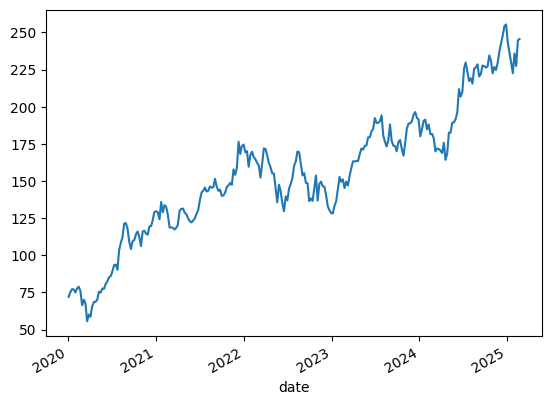

In [34]:
data_new_week['Close'].plot()

#### 1.3 Candle Chart

완성된 OHLCV 데이터는 candle chart로 직관적으로 표현 가능하다. 실제로 대부분의 product가 캔들 차트로 되어있다는 점을 유의하자.

In [35]:
up = data_new_week['Close'] > data_new_week['Open']  # 양봉 (상승)
down = data_new_week['Close'] < data_new_week['Open']  # 음봉 (하락)

캔들 차트의 특징은 다음과 같다.

- 시가보다 종가가 높은 경우 양봉(Bullish)이라 하며, 한국에서는 적색, 미국에서는 녹색으로 표기한다
- 시가보다 종가가 낮은 경우 음봉(Bearish)이라 하며, 한국에서는 청색, 미국에서는 적색으로 표기한다

각 캔들에서 두꺼운 선의 양 끝점은 시가와 종가를 나타내며, 얇은 선(꼬리)의 양끝은 각각 저가와 고가를 나타낸다

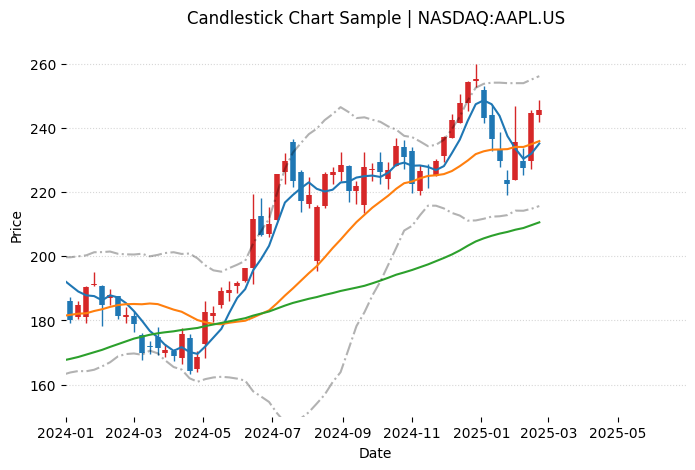

In [43]:
import datetime

fig, ax = plt.subplots(figsize = (8, 5))

ax.vlines(data_new_week.index[up], data_new_week['Low'][up], data_new_week['High'][up], 
          color='tab:red', linewidth=1)
ax.vlines(data_new_week.index[up], data_new_week['Open'][up], data_new_week['Close'][up], 
          color='tab:red', linewidth=4)

ax.vlines(data_new_week.index[down], data_new_week['Low'][down], data_new_week['High'][down], 
          color='tab:blue', linewidth=1)
ax.vlines(data_new_week.index[down], data_new_week['Open'][down], data_new_week['Close'][down], 
          color='tab:blue', linewidth=4)

ax.plot(data_new_week['Close'].rolling(5).mean())
ax.plot(data_new_week['Close'].rolling(20).mean())
ax.plot(data_new_week['Close'].rolling(60).mean())

ax.plot(data_new_week['Close'].rolling(20).mean() + 2 * data_new_week['Close'].rolling(20).std(), color = 'k', alpha = 0.3, ls='-.')
ax.plot(data_new_week['Close'].rolling(20).mean() - 2 * data_new_week['Close'].rolling(20).std(), color = 'k', alpha = 0.3, ls='-.')

ax.set_title('Candlestick Chart Sample | NASDAQ:AAPL.US')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.xlim(
    datetime.datetime(2024, 1, 1),
    datetime.datetime(2025, 6, 30)
)
plt.ylim([150, 270])

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

### 2. Return Rate

주가 계산 이후 가장 많이 실수하는 것 중 하나가 바로 수익률에 대한 계산이다. 올바른 주가 수익률 계산에 대해 알아보고 성과 추정에 대해 살펴본다.

#### 2.1 Simple Return Rate

Simple Return Rate는 다음과 같이 계산된다

$$r_t = \frac{P_{t} - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

수익률 계산에서 가장 많이 실수하는 것 중 하나는 log return(로그 수익률)을 사용하는 것인데, 이는 학술 연구에서 수익률을 정규분포에 근사하기 위해 proxy로 사용되는 것일 뿐, 실제 환경에서는 로그 수익률을 사용하면 장기간 수익에 대해서 왜곡이 발생한다.

$$r_t = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

In [44]:
log_ret = np.log(data_new_week['Close'] / data_new_week['Close'].shift(1))
ret = data_new_week['Close'].pct_change(fill_method = None)

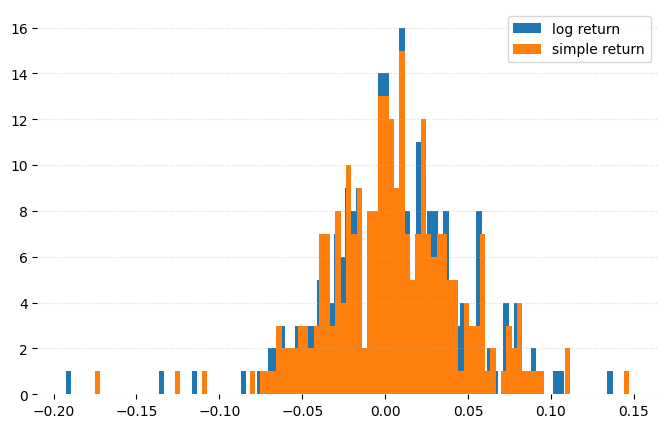

In [45]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.hist(log_ret, bins = 100, label = 'log return')
ax.hist(ret, bins = 100, label = 'simple return')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.show()

위 분포의 개형만 보아도, simple return에 비해 log return은 수익률을 **과소 추정**하는 경향이 강하다. 이는 시계열이 길어질수록 차이가 더 두드러진다

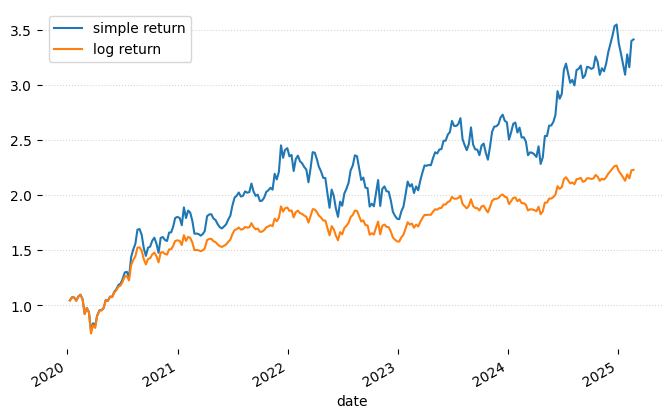

In [46]:
fig, ax = plt.subplots(figsize = (8, 5))

(1 + ret).cumprod().plot(ax = ax, label = 'simple return')
(log_ret.cumsum() + 1).plot(ax = ax, label = 'log return')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.show()

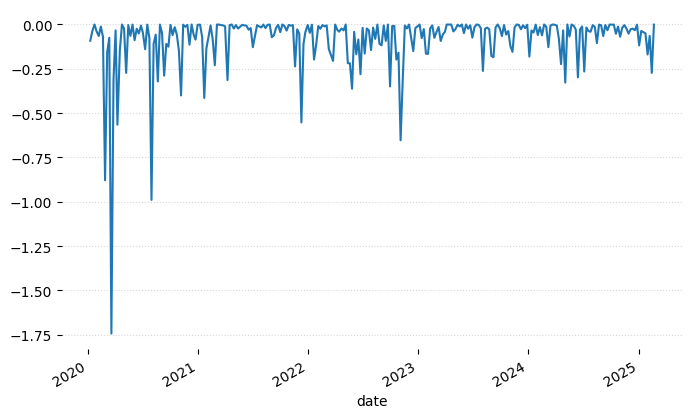

In [47]:
fig, ax = plt.subplots(figsize = (8, 5))

((log_ret - ret) * 100).plot(ax = ax)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.show()

#### 2.2 Year to Date

수익률 계산에 있어서 두 번째 실수는 YTD(Year to Date) 누적 수익률을 계산하는 것이다. 연간 수익률을 계산한다면 1월 1일 기준 가격이 아닌 **전년도 최종 종가**를 기준으로 계산해야 한다.

In [48]:
print(f'ytd return rate of 2021 : {(data.loc["2021","Close"].iloc[-1] / data.loc["2020", "Close"].iloc[-1]-1) * 100:.2f}%')
print(f'ytd return rate of 2022 : {(data.loc["2022","Close"].iloc[-1] / data.loc["2021", "Close"].iloc[-1]-1) * 100:.2f}%')
print(f'ytd return rate of 2023 : {(data.loc["2023","Close"].iloc[-1] / data.loc["2022", "Close"].iloc[-1]-1) * 100:.2f}%')
print(f'ytd return rate of 2024 : {(data.loc["2024","Close"].iloc[-1] / data.loc["2023", "Close"].iloc[-1]-1) * 100:.2f}%')
print(f'ytd return rate of 2025 : {(data.loc["2025","Close"].iloc[-1] / data.loc["2024", "Close"].iloc[-1]-1) * 100:.2f}%')

ytd return rate of 2021 : 34.65%
ytd return rate of 2022 : -26.40%
ytd return rate of 2023 : 49.01%
ytd return rate of 2024 : 30.71%
ytd return rate of 2025 : -1.84%


#### 2.3 Annualized Return Rate

Sharpe Ratio 혹은 아직 회기년도가 끝나지 않는 수익률에 대해서 연율화를 하는 경우가 종종 존재하는데, 이 경우 연율화를 주기에 따라 다르게 적용해야 한다. 

In [103]:
print(f"Annualized return rate of 2025, based on weekly return : {data_new_week['Close'].pct_change(fill_method=None).loc['2025'].mean() * 100 * 52: .2f}%")
print(f"Annualized std of 2025, based on weekly return : {data_new_week['Close'].pct_change(fill_method=None).loc['2025'].std() * 100 * np.sqrt(52): .2f}%")

Annualized return rate of 2025, based on weekly return : -16.04%
Annualized std of 2025, based on weekly return :  33.80%


In [104]:
print(f"Annualized return rate of 2024, based on weekly return : {data_new_week['Close'].pct_change(fill_method=None).loc['2024'].mean() * 100 * 52: .2f}%")
print(f"Annualized std of 2024, based on weekly return : {data_new_week['Close'].pct_change(fill_method=None).loc['2024'].std() * 100 * np.sqrt(52): .2f}%")

Annualized return rate of 2024, based on weekly return :  31.38%
Annualized std of 2024, based on weekly return :  22.58%
